### Building an ANN

### Input is MNIST Fashion dataset, to classify fashion articles. 28x28 pictures.

### 4 layers, 1 input layer (784), 2 hidden layers(128 and 64) and 1 output layer (10)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
import zipfile
import os

file_path = "/content/archive.zip"
output_dir = "/content/"

os.makedirs(output_dir, exist_ok=True)

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"File extracted to {output_dir}")

File extracted to /content/


In [6]:
df = pd.read_csv("/content/fashion-mnist_train.csv")

In [7]:
df.shape

(60000, 785)

In [ ]:
# df = df.sample(n=6000, random_state=42)

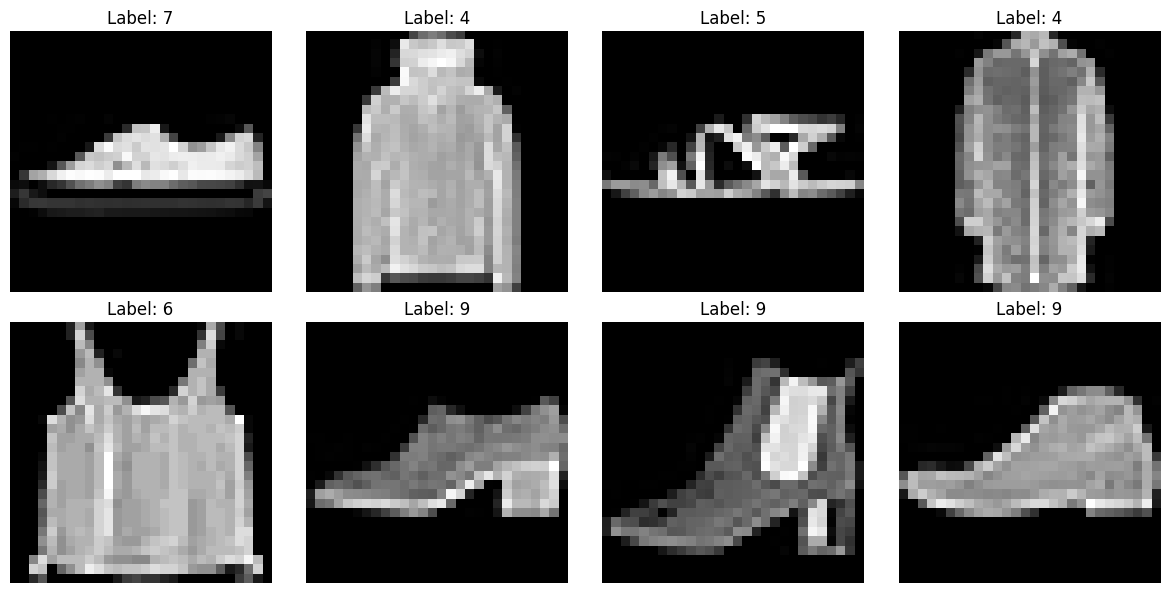

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Select 8 random indices
random_indices = np.random.choice(df.index, size=8, replace=False)

# Get the images and labels for the selected indices
random_images = df.loc[random_indices, df.columns != 'label'].values
random_labels = df.loc[random_indices, 'label'].values

# Reshape the images to 28x28
random_images = random_images.reshape(-1, 28, 28)

# Display the images
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(random_images[i], cmap='gray')
    plt.title(f"Label: {random_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
display(df['label'].value_counts().sort_index())

,count
label,
0,6000
1,6000
2,6000
3,6000
4,6000
5,6000
6,6000
7,6000
8,6000


In [10]:
# test train split

x = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [11]:
# scaling

x_train = x_train/255.0
x_test = x_test/255.0

In [12]:
# create customdataset class

class CustomDataset(Dataset):

  def __init__(self, features, labels):
    self.features = torch.tensor(features,dtype=torch.float32)
    self.labels = torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [13]:
# create train_dataset object

train_dataset = CustomDataset(x_train, y_train)

In [14]:
len(train_dataset)
train_dataset[1]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [15]:
# create test_dataset object

test_dataset = CustomDataset(x_test, y_test)

In [ ]:
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [16]:
class MyNN(nn.Module):

  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):
    super().__init__()

    layers = []

    for i in range(num_hidden_layers):
        layers.append(nn.Linear(input_dim, neurons_per_layer))
        layers.append(nn.BatchNorm1d(neurons_per_layer))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer, output_dim))   # output layer

    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

In [17]:
# OPTUNA OBJECTIVE FUNCTION

def objective(trial):

    # next hyperparameter values from the search space
    num_hidden_layers = trial.suggest_int("num_hidden_layers",1 ,5)
    neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
    epochs = trial.suggest_int("epochs", 10, 50)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step = 0.1)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSProp"])
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True)

    # model

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # model init
    input_dim = 784
    output_dim = 10

    model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
    model.to(device)

    # params init
    # learning_rate = 0.01
    # epochs = 50

    # optimizer selection
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay)

    if optimizer_name == "Adam":
      optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
    elif optimizer_name == "SGD":
      optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
    elif optimizer_name == "RMSProp":
      optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay = weight_decay)

    # training loop
    for epoch in range(epochs):

      total_epoch_loss = 0

      for batch_features, batch_labels in train_loader:

        # move data to gpu
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        # forward pass
        outputs = model(batch_features)

        # calcultae loss
        loss = criterion(outputs, batch_labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update grads
        optimizer.step()

    # evaluation
    model.eval()

    # evaluation code

    total = 0
    correct = 0

    with torch.no_grad():
      for batch_features, batch_labels in test_loader:

        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)
        total = total + batch_labels.shape[0]
        correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total

    return accuracy

In [18]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 22.8 MB/s eta 0:00:00


In [19]:
import optuna

study = optuna.create_study(direction='maximize') # since accuracy

[I 2025-08-02 12:59:05,960] A new study created in memory with name: no-name-406b77c1-da02-4178-bffa-287fe9cab2e1


In [ ]:
study.optimize(objective, n_trials=25)

In [ ]:
print(study.best_value, "for the following parameters:")
print(study.best_params)

In [ ]:
## USE MLFLOW WITH THIS TO IMPROVE AND GET AN IDEA OF WHAT WORKS BEST

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=10, bias=True)
  )
)